# Задание 3. Использование метрик линеаризованных лайков

## Задание


* Проанализируйте тест между группами 0 и 3 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?
* Проанализируйте тест между группами 1 и 2 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше??

## Загружаем необходимые библиотеки. Выгрузим из нашей базы необходимые данные: юзеров, их просмотры, лайки, а также значение CTR.

In [1]:
import pandahouse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import hashlib 
from scipy import stats # статистика
%matplotlib inline
sns.set()

In [2]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20220920'
}

q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-09-03' and '2022-09-09'
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

In [3]:
df.head()

,exp_group,user_id,likes,views,ctr
0,3,115383,9,30,0.300000
1,1,18392,7,32,0.218750
2,2,131473,14,134,0.104478
3,3,123580,13,48,0.270833
4,4,107323,5,31,0.161290


### Разделим наш датафрейм на два. В одном будут юзеры из контрольной группы 0 и тестовой 3. Во втором датафрейме будут юзеры из контрольной группы 1 и тестовой 2.

In [56]:
df0_3 = df[(df.exp_group == 0) | (df.exp_group == 3)].copy()
df1_2 = df[(df.exp_group == 1) | (df.exp_group == 2)].copy()

In [57]:
df0_3.head()

,exp_group,user_id,likes,views,ctr
0,3,115383,9,30,0.300000
3,3,123580,13,48,0.270833
7,0,30319,21,110,0.190909
9,3,118359,7,38,0.184211
11,0,7626,14,39,0.358974


In [58]:
df1_2.head()

,exp_group,user_id,likes,views,ctr
1,1,18392,7,32,0.218750
2,2,131473,14,134,0.104478
5,2,32420,26,128,0.203125
6,2,24239,40,90,0.444444
8,1,27443,2,29,0.068966


### Считаем общий CTR в для контрольной группы 0  𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙=𝑠𝑢𝑚(𝑙𝑖𝑘𝑒𝑠)/𝑠𝑢𝑚(𝑣𝑖𝑒𝑤𝑠)

In [73]:
CTRcontrol_0 = df0_3[df0_3.exp_group == 0].likes.sum()/df0_3[df0_3.exp_group == 0].views.sum()


In [77]:
CTRcontrol_1

0.20802680490126244

### Рассчитаем показатель линеаризованных лайков для групп 0 и 3.

In [60]:
df0_3['linearized_likes'] = df0_3.likes - CTRcontrol_0 * df0_3.views

In [61]:
df0_3.head()

,exp_group,user_id,likes,views,ctr,linearized_likes
0,3,115383,9,30,0.300000,2.752916
3,3,123580,13,48,0.270833,3.004666
7,0,30319,21,110,0.190909,-1.905973
9,3,118359,7,38,0.184211,-0.912973
11,0,7626,14,39,0.358974,5.878791


### Построим гистограмму распределений значений CTR для групп 0 и 3, а затем гистограмму распределений линеаризованных лайков и сравним результат.

<AxesSubplot:xlabel='ctr', ylabel='Count'>

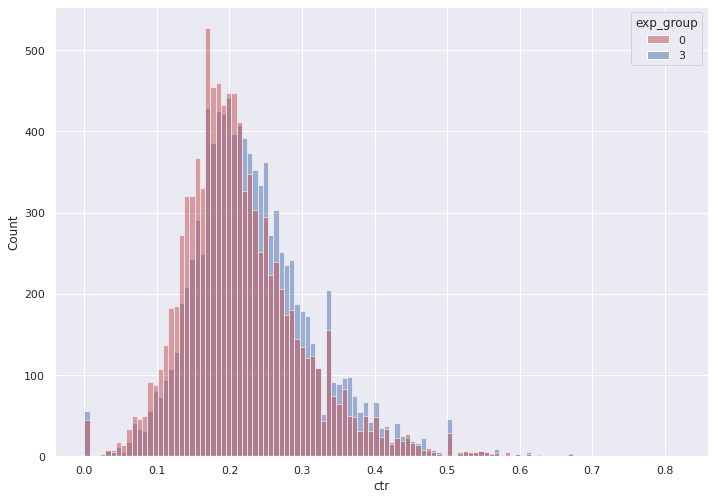

In [62]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.histplot(data = df0_3, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

<AxesSubplot:xlabel='linearized_likes', ylabel='Count'>

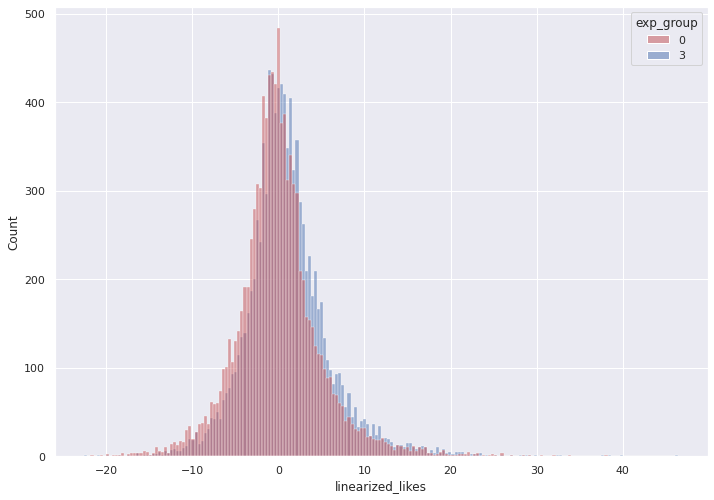

In [63]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.histplot(data = df0_3, 
              x='linearized_likes', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

**Как видим, распределение CTR слегка скошено в левую сторону и имеет вытянутый хвост в правую сторону, в то время как распределение линеаризованных лайков близко к нормальному, без вытянутых хвостов и меньшим количеством выбросов.**

### Проведем t-тест и тест Манна-Уитни сначала на CTR, а затем на линеаризованных лайках для групп 0 и 3 и сравним результаты.

**T-Тест для CTR.**

In [68]:
t_test = stats.ttest_ind(df0_3[df0_3.exp_group == 0].ctr,
                df0_3[df0_3.exp_group == 3].ctr,
                equal_var=False)[1]
print('p-value =',t_test)
if t_test < 0.05:
    print("Разница между средними значениями CTR групп 0 и 3 статистически значимая.")
else:     
    print("Между средними значениями CTR групп 0 и 3 отстутствует статистически значимая разница.")


p-value = 1.055849414662529e-43
Разница между средними значениями CTR групп 0 и 3 статистически значимая.


**Тест Манна-Уитни для CTR.**

In [70]:
t_testmw = stats.mannwhitneyu(df0_3[df0_3.exp_group == 0].ctr,
                df0_3[df0_3.exp_group == 3].ctr,
                alternative='two-sided')[1]
print('p-value = {}'.format(t_testmw))
if t_testmw < 0.05:
    print("Разница между средними значениями CTR групп 0 и 3 статистически значимая.")
else:     
    print("Между средними значениями CTR групп 0 и 3 отстутствует статистически значимая разница.")

p-value = 1.1952055473582936e-57
Разница между средними значениями CTR групп 0 и 3 статистически значимая.


**T-Тест для линеаризованных лайков.**

In [69]:
t_test = stats.ttest_ind(df0_3[df0_3.exp_group == 0].linearized_likes,
                df0_3[df0_3.exp_group == 3].linearized_likes,
                equal_var=False)[1]
print('p-value =',t_test)
if t_test < 0.05:
    print("Разница между средними значениями CTR групп 0 и 3 статистически значимая.")
else:     
    print("Между средними значениями CTR групп 0 и 3 отстутствует статистически значимая разница.")


p-value = 5.4914249479690016e-52
Разница между средними значениями CTR групп 0 и 3 статистически значимая.


**Тест Манна-Уитни для линеаризованных лайков.**

In [71]:
t_testmw = stats.mannwhitneyu(df0_3[df0_3.exp_group == 0].linearized_likes,
                df0_3[df0_3.exp_group == 3].linearized_likes,
                alternative='two-sided')[1]
print('p-value = {}'.format(t_testmw))
if t_testmw < 0.05:
    print("Разница между средними значениями CTR групп 0 и 3 статистически значимая.")
else:     
    print("Между средними значениями CTR групп 0 и 3 отстутствует статистически значимая разница.")

p-value = 1.1517315029786597e-63
Разница между средними значениями CTR групп 0 и 3 статистически значимая.


**Оба теста, проведенные на метриках CTR и линеаризованных лайках, подтверждают статистически значимую разницу между группами. При этом значения p-value стали ещё меньше при использовании новой метрики linearized likes. Возможно, это связано с тем, что новая метрика имеет распределение, близкое к нормальному.**

### Сравним между собой группы 1 и 2

#### Рассчитаем глобальный CTR контрольной группы 1

In [75]:
CTRcontrol_1 = df1_2[df1_2.exp_group == 1].likes.sum()/df1_2[df1_2.exp_group == 1].views.sum()

In [76]:
CTRcontrol_1

0.20802680490126244

#### Рассчитаем показатель линеаризованных лайков для групп 1 и 2.

In [78]:
df1_2['linearized_likes'] = df1_2.likes - CTRcontrol_0 * df1_2.views

In [80]:
df1_2.head()

,exp_group,user_id,likes,views,ctr,linearized_likes
1,1,18392,7,32,0.218750,0.336444
2,2,131473,14,134,0.104478,-13.903640
5,2,32420,26,128,0.203125,-0.654224
6,2,24239,40,90,0.444444,21.258749
8,1,27443,2,29,0.068966,-4.038848


#### Построим гистограмму распределений значений CTR для групп 1 и 2, а затем гистограмму распределений линеаризованных лайков и сравним результат.

In [79]:
df1_2.head()

,exp_group,user_id,likes,views,ctr,linearized_likes
1,1,18392,7,32,0.218750,0.336444
2,2,131473,14,134,0.104478,-13.903640
5,2,32420,26,128,0.203125,-0.654224
6,2,24239,40,90,0.444444,21.258749
8,1,27443,2,29,0.068966,-4.038848


<AxesSubplot:xlabel='ctr', ylabel='Count'>

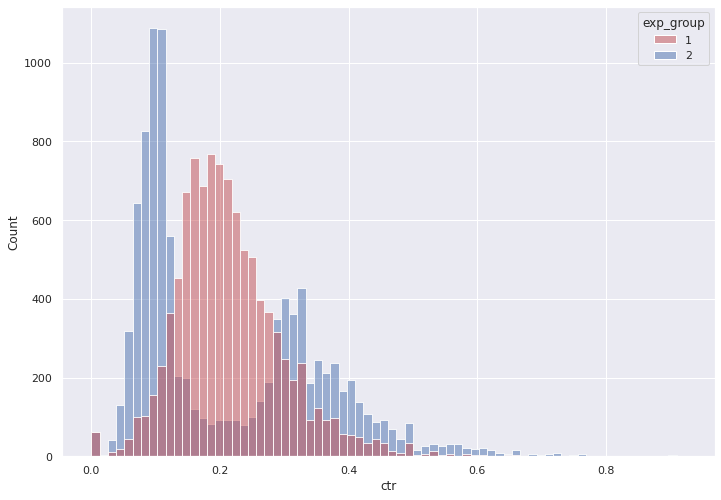

In [81]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.histplot(data = df1_2, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

<AxesSubplot:xlabel='linearized_likes', ylabel='Count'>

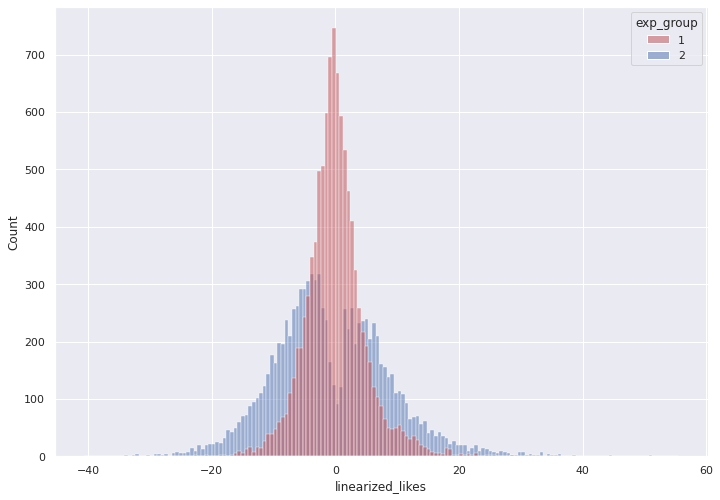

In [82]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.histplot(data = df1_2, 
              x='linearized_likes', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

**Как видно из графиков, распределение CTR для первой группы близко к нормальному, при этом слегка скошено в лево. Распределение CTR для второй группы является асимметиричны, бимодальным, с наличием хвоста в правую сторону. Распределение линеаризованных лайков отличается от CTR. Для первой группы распределение практически нормальное с наибольшим количеством значений в центре, без длинных хвостов и выбросов. Для группы 2 распределение осталось бимодальным, однако расстояние между двумя горбами сжалось, распределение стало не таким растянутым и скошенным. Обе вершины находятся практически в центре распределения с просадкой количества юзеров со значением линеаризованных лайков около 0.**

### Проведем t-тест и тест Манна-Уитни сначала на CTR, а затем на линеаризованных лайках для групп 1 и 2 и сравним результаты.

**T-Тест для CTR.**

In [85]:
t_test = stats.ttest_ind(df1_2[df1_2.exp_group == 1].ctr,
                df1_2[df1_2.exp_group == 2].ctr,
                equal_var=False)[1]
print('p-value =',t_test)
if t_test < 0.05:
    print("Разница между средними значениями CTR групп 1 и 2 статистически значимая.")
else:     
    print("Между средними значениями CTR групп 1 и 2 отстутствует статистически значимая разница.")

p-value = 0.4780623130874935
Между средними значениями CTR групп 1 и 2 отстутствует статистически значимая разница.


**Тест Манна-Уитни для CTR.**

In [86]:
t_testmw = stats.mannwhitneyu(df1_2[df1_2.exp_group == 1].ctr,
                df1_2[df1_2.exp_group == 2].ctr,
                alternative='two-sided')[1]
print('p-value = {}'.format(t_testmw))
if t_testmw < 0.05:
    print("Разница между средними значениями CTR групп 1 и 2 статистически значимая.")
else:     
    print("Между средними значениями CTR групп 1 и 2 отстутствует статистически значимая разница.")

p-value = 6.0376484617779035e-56
Разница между средними значениями CTR групп 1 и 2 статистически значимая.


**T-Тест для линеаризованных лайков.**

In [87]:
t_test = stats.ttest_ind(df1_2[df1_2.exp_group == 1].linearized_likes,
                df1_2[df1_2.exp_group == 2].linearized_likes,
                equal_var=False)[1]
print('p-value =',t_test)
if t_test < 0.05:
    print("Разница между средними значениями CTR групп 1 и 2 статистически значимая.")
else:     
    print("Между средними значениями CTR групп 1 и 2 отстутствует статистически значимая разница.")

p-value = 9.544973454280379e-10
Разница между средними значениями CTR групп 1 и 2 статистически значимая.


**Тест Манна-Уитни для линеаризованных лайков.**

In [88]:
t_testmw = stats.mannwhitneyu(df1_2[df1_2.exp_group == 1].linearized_likes,
                df1_2[df1_2.exp_group == 2].linearized_likes,
                alternative='two-sided')[1]
print('p-value = {}'.format(t_testmw))
if t_testmw < 0.05:
    print("Разница между средними значениями CTR групп 1 и 2 статистически значимая.")
else:     
    print("Между средними значениями CTR групп 1 и 2 отстутствует статистически значимая разница.")

p-value = 1.006515749432423e-26
Разница между средними значениями CTR групп 1 и 2 статистически значимая.


**В отличие от t-теста, проведенного на CTR, тест на линеаризованных лайках показал наличие статистически значимой разницы между группами. Тест Манна-Уитни был утвердительным в обоих случаях. Изменения в t-тесте можно объяснить "нормализацией" распределения, уменьшением числа выбросов и дляны хвостов. Можно сделать вывод, что показатель линеаризованных лайков достаточно эффективен как метрика для наших тестов. Результаты тестирования совпадают с Пуассоновским бутстрепом, тестом Манна-Уитни и бакетнымм преобразованием для CTR и уменьшают риск влияния неравномерного распределения на t-тест.**